In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import cv2

images_directory = '/content/gdrive/MyDrive/Cardiac_Catheterization/train/images/'
masks_directory = '/content/gdrive/MyDrive/Cardiac_Catheterization/train/masks/'

images_files = os.listdir(images_directory)
masks_files = os.listdir(masks_directory)

sample_image = cv2.imread(images_directory + images_files[0], flags=cv2.IMREAD_GRAYSCALE)

print('images count: ' + str(len(images_files)))
print('images shape: ' + str(sample_image.shape))

images count: 1717
images shape: (512, 512)


In [ ]:
image_size = 128
images_dataset = []
masks_dataset = []

for i, image_name in enumerate(images_files):
    image = cv2.imread(images_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    images_dataset.append(image)

for i, image_name in enumerate(masks_files):
    image = cv2.imread(masks_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    masks_dataset.append(image)


images_dataset = np.expand_dims((np.array(images_dataset)), axis=3) / 255.
masks_dataset = np.expand_dims((np.array(masks_dataset)), axis=3) / 255.

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images_dataset, masks_dataset, test_size=0.2, random_state=0)

del images_files
del masks_files
del images_dataset
del masks_dataset

print('images shape: ' + str(x_train[0].shape))
print('masks shape: ' + str(y_train[0].shape))


images shape: (128, 128, 1)
masks shape: (128, 128, 1)


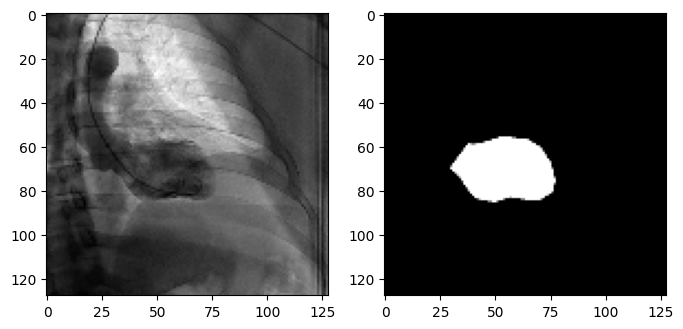

In [ ]:
import random
from matplotlib import pyplot as plt

random_index = random.randint(0, len(x_train))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(x_train[random_index], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y_train[random_index], cmap='gray')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend


def jacard_coefficient(y_true, y_pred):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (backend.sum(y_true_f) + backend.sum(y_pred_f) - intersection + 1.0)


def conv_block(x, filter_size, size, dropout, batch_norm):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def u_net(input_shape, num_classes, dropout_rate, batch_norm):
    filter_num = 64
    filter_size = 3
    up_sample_size = 2

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # DownSampling

    conv_128 = conv_block(inputs, filter_size, filter_num, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128)

    conv_64 = conv_block(pool_64, filter_size, 2 * filter_num, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64)

    conv_32 = conv_block(pool_32, filter_size, 4 * filter_num, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32)

    conv_16 = conv_block(pool_16, filter_size, 8 * filter_num, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16)

    conv_8 = conv_block(pool_8, filter_size, 16 * filter_num, dropout_rate, batch_norm)

    # UpSampling
    
    up_16 = layers.UpSampling2D(size=(up_sample_size, up_sample_size), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, filter_size, 8 * filter_num, dropout_rate, batch_norm)

    up_32 = layers.UpSampling2D(size=(up_sample_size, up_sample_size), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, filter_size, 4 * filter_num, dropout_rate, batch_norm)

    up_64 = layers.UpSampling2D(size=(up_sample_size, up_sample_size), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, filter_size, 2 * filter_num, dropout_rate, batch_norm)

    up_128 = layers.UpSampling2D(size=(up_sample_size, up_sample_size), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, filter_size, filter_num, dropout_rate, batch_norm)

    # Convert to one dimension
    conv_final = layers.Conv2D(num_classes, kernel_size=(1, 1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  # Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model


In [ ]:
from focal_loss import BinaryFocalLoss

input_shape = (image_size, image_size, 1)

model = u_net(input_shape, num_classes=1, dropout_rate=0, batch_norm=False)
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[jacard_coefficient])

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                              

In [ ]:
batch_size = 16
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=False, epochs=epochs)
model.evaluate(x_test,y_test)
model.save('u_net_model.hdf5')

Epoch 1/20
86/86 [==============================] - 56s 320ms/step - loss: 0.1169 - jacard_coefficient: 0.2149 - val_loss: 0.1176 - val_jacard_coefficient: 0.2159
Epoch 2/20
86/86 [==============================] - 18s 212ms/step - loss: 0.0670 - jacard_coefficient: 0.2704 - val_loss: 0.0780 - val_jacard_coefficient: 0.2547
Epoch 3/20
86/86 [==============================] - 20s 228ms/step - loss: 0.0546 - jacard_coefficient: 0.2896 - val_loss: 0.0572 - val_jacard_coefficient: 0.3019
Epoch 4/20
86/86 [==============================] - 20s 231ms/step - loss: 0.0456 - jacard_coefficient: 0.3058 - val_loss: 0.0437 - val_jacard_coefficient: 0.3187
Epoch 5/20
86/86 [==============================] - 19s 219ms/step - loss: 0.0387 - jacard_coefficient: 0.3205 - val_loss: 0.0358 - val_jacard_coefficient: 0.3332
Epoch 6/20
86/86 [==============================] - 19s 219ms/step - loss: 0.0338 - jacard_coefficient: 0.3328 - val_loss: 0.0324 - val_jacard_coefficient: 0.3557
Epoch 7/20
86/86 [====

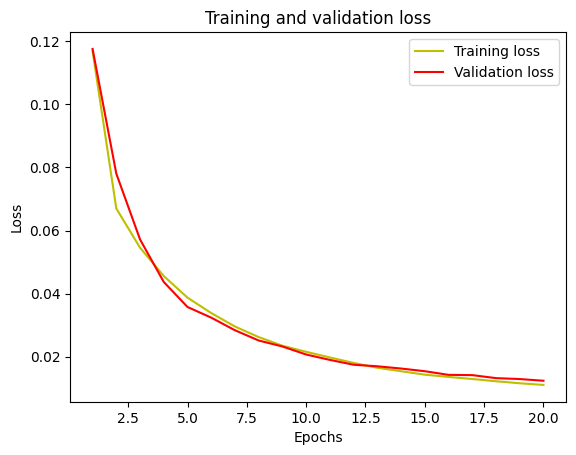

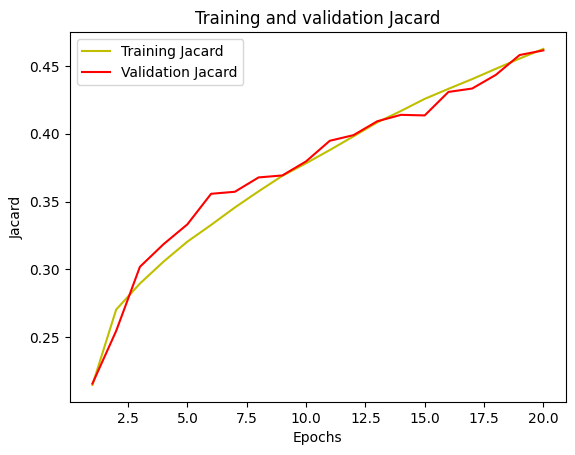

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coefficient']
val_acc = history.history['val_jacard_coefficient']
plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

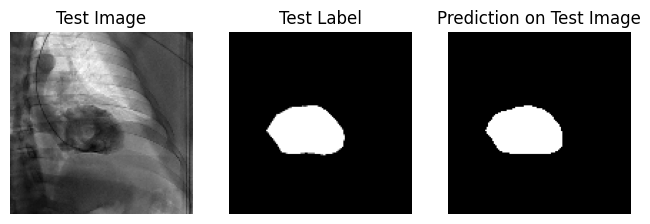

In [ ]:
import random

random_index = random.randint(0, len(x_test))

x = x_test[random_index]
y = y_test[random_index]
prediction = model.predict(np.array([x]), verbose=0)[0]
prediction = (prediction > 0.5).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.subplot(2, 3, 1)
plt.title('Test Image')
plt.axis('off')
plt.imshow(x, cmap='gray')
plt.subplot(2, 3, 2)
plt.title('Test Label')
plt.axis('off')
plt.imshow(y, cmap='gray')
plt.subplot(2, 3, 3)
plt.title('Prediction on Test Image')
plt.axis('off')
plt.imshow(prediction, cmap='gray')

plt.show()